In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
% matplotlib inline

C:\Users\Hong Jie\Anaconda3\envs\python35\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
def load_matching_data(path_to_data, key, match_values, chunksize=30000, set_index=True):
    df = pd.read_json(path_to_data, lines=True, orient='columns', chunksize=chunksize)
    final = []
    for chunk in df:
        final.append(chunk[chunk[key].isin(match_values)])
    if set_index:
        return pd.concat(final).set_index(key)
    else:
        return pd.concat(final)

def preprocess(review_filename, user_filename, business_ids):
    reviews = load_matching_data(review_filename,
                                 key='business_id',
                                 match_values=business_ids,
                                 chunksize=20000)
    customers = reviews.user_id.drop_duplicates().tolist()
    users = load_matching_data(user_filename,
                               key='user_id',
                               match_values=customers,
                               chunksize=20000)

    df = reviews.merge(users, how='left', left_on='user_id', right_index=True)
    df['year'] = df.date.dt.year.astype(str)
    df['is_elite'] = [x in y for x, y in zip(df.year.tolist(), df.elite.tolist())]
    df['influence'] = df.is_elite.astype(int) * 100 + df.useful_x + df.funny_x \
                                                    + df.cool_x + df.fans + 1

    top5pct = int(0.05 * users.shape[0])
    # take top 5% by total review influence as influencers
    influencers = df.groupby('user_id')['influence'].sum()\
                    .sort_values(ascending=False)[:top5pct]\
                    .index.tolist()
    df['adj_stars'] = df.stars - df.average_stars
    df['influencer_rating'] = df.user_id.isin(influencers) * df.adj_stars # adjust for avg stars
    
    df.date = df.date.dt.date
    nlp = SentimentIntensityAnalyzer()
    df['sentiment'] = df.text.apply(lambda x: nlp.polarity_scores(x)['compound'])
    return df

def preprocess_checkins(checkin_filename, business_ids):
    checkins = load_matching_data(checkin_filename, 
                                  key='business_id',
                                  match_values=business_ids,
                                  chunksize=20000,
                                  set_index=False)
    checkins.date = checkins.date.str.split(', ')
    checkin_times = pd.DataFrame(pd.to_datetime(checkins.date.sum()),
                                 columns=['datetime'])
    checkin_times['dummy'] = 1
    checkin_times['date'] = checkin_times.datetime.dt.date
    checkin_times = checkin_times.groupby('date')['dummy'].sum()\
                                .asfreq('D').fillna(0.)
    return checkin_times

# EDA

## reviews

In [26]:
# for reading in raw json
num_reviews = 100000
df = pd.read_json(root + '/review.json', lines=True, orient='columns', chunksize=num_reviews)
for review in df:
    #review = chunk
    break
review.set_index('review_id', inplace=True)
review.head()

,business_id,cool,date,funny,stars,text,useful,user_id
review_id,,,,,,,,
Q1sbwvVQXV2734tPgoKj4Q,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
GJXCdrto3ASJOqKeVWPi6Q,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2TzJjDVDEuAW6MR5Vuc1ug,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
11a8sVPMUFtaC7_ABRkmtw,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


## business id

In [3]:
# for reading in raw json
#num_reviews = 192609
business = pd.read_json('yelp_dataset/business.json', lines=True, orient='columns')
business.set_index('business_id', inplace=True)
business.head()

,address,attributes,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
business_id,,,,,,,,,,,,,
1SWheh84yJXfytovILXOAQ,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
QXAEGFB4oINsVuTFxEYKFQ,30 Eglinton Avenue W,"{'NoiseLevel': 'u'loud'', 'Ambience': '{'roman...","Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Saturday': '9:0-1:0', 'Wednesday': '9:0-0:0'...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
gnKjwL_1w79qoiV3IC_xQQ,"10110 Johnston Rd, Ste 15","{'NoiseLevel': 'u'average'', 'Ambience': '{'ro...","Sushi Bars, Restaurants, Japanese",Charlotte,"{'Saturday': '17:30-22:0', 'Wednesday': '17:30...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
xvX2CttrVhyG2z1dFg_0xw,"15655 W Roosevelt St, Ste 237",None,"Insurance, Financial Services",Goodyear,"{'Wednesday': '8:0-17:0', 'Friday': '8:0-17:0'...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
HhyxOkGAM07SRYtlQ4wMFQ,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'BusinessA...","Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Saturday': '7:0-23:0', 'Wednesday': '7:0-23:...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [4]:
cheesecake = business[business.name == 'The Cheesecake Factory']
shakeshack = business[business.name == 'Shake Shack']
innout = business[business.name == 'In-N-Out Burger']

# EDA plots for slides

In [5]:
# load checkins
checkins = load_matching_data('./yelp_dataset/checkin.json', 
                              key='business_id',
                              match_values=innout.index.tolist(),
                              chunksize=20000,
                              set_index=False)

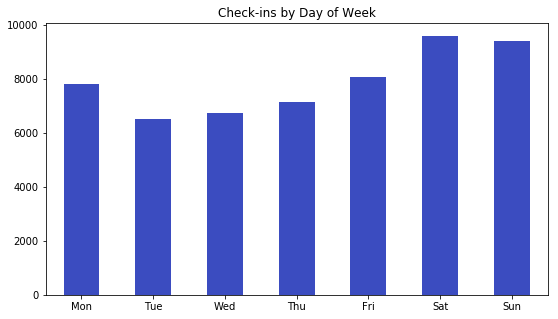

In [6]:
checkins.date = checkins.date.str.split(', ')
checkins_dayofweek = pd.to_datetime(checkins.date.sum()).dayofweek.value_counts() # sat and sun top

checkins_dayofweek.reindex(index=range(7))\
                    .rename(index=dict(zip(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])))\
                    .plot.bar(figsize=(9,5), cmap='coolwarm', rot=0);
plt.title('Check-ins by Day of Week');

In [7]:
checkins['count'] = checkins.date.apply(len)

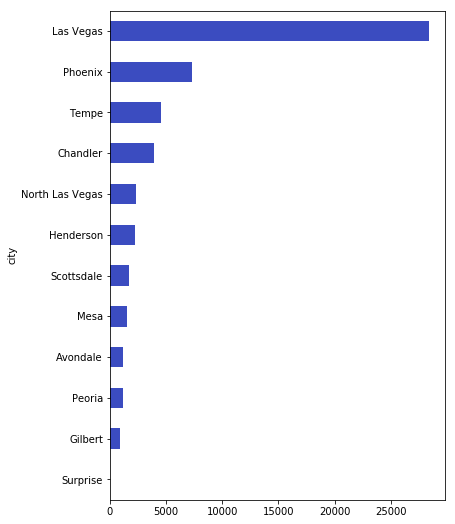

In [12]:
business.merge(checkins, 'inner', left_index=True, right_on='business_id')\
        .groupby('city')['count'].sum().sort_values(ascending=True).plot.barh(figsize=(6,9), cmap='coolwarm');

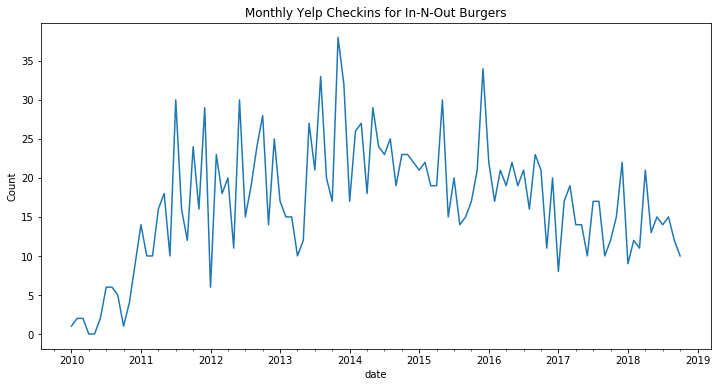

In [141]:
checkin_times.asfreq('M').plot(figsize=(12,6));
plt.title('Monthly Yelp Checkins for In-N-Out Burgers')
plt.ylabel('Count');

# In-N-Out

Get all business Ids, get all reviews on all business locations and join.

In [13]:
df_innout = preprocess('yelp_dataset/review.json', 'yelp_dataset/user.json', innout.index.tolist())
checkin_times = preprocess_checkins('./yelp_dataset/checkin.json', innout.index.tolist())

In [14]:
endog = df_innout.groupby('date').agg({'adj_stars':np.mean,
                                      'sentiment':np.mean,
                                      'influencer_rating':np.sum})
endog = endog.asfreq('D').fillna(0.0)
endog['checkins'] = checkin_times

In [15]:
endog = endog.dropna()

In [52]:
# def test_vader(index, df):
#     print(df.text[index])
#     print('Combined: %.3f' % nlp.polarity_scores(df.text[index])['compound'])
#     print('Averaged: %.3f' % np.mean([nlp.polarity_scores(x)['compound']
#                                   for x in df.text[index].split('.')]))
#     print('')

# [test_vader(i, df_innout) for i in range(10)]

## Explore time series

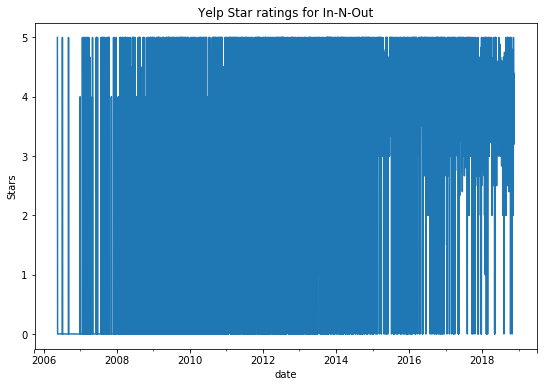

In [23]:
endog['stars'].plot(figsize=(9,6));
plt.title('Yelp Star ratings for In-N-Out')
plt.ylabel('Stars');

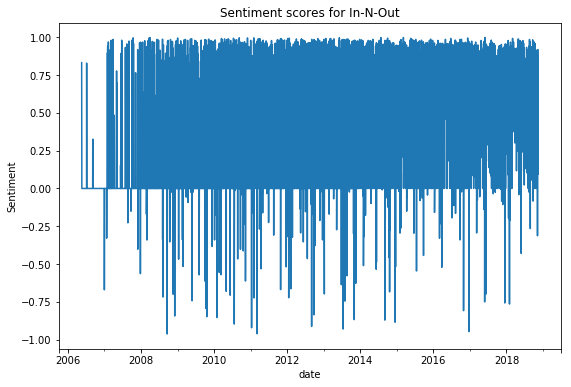

In [60]:
endog['sentiment'].plot(figsize=(9,6));
plt.title('Sentiment scores for In-N-Out')
plt.ylabel('Sentiment');

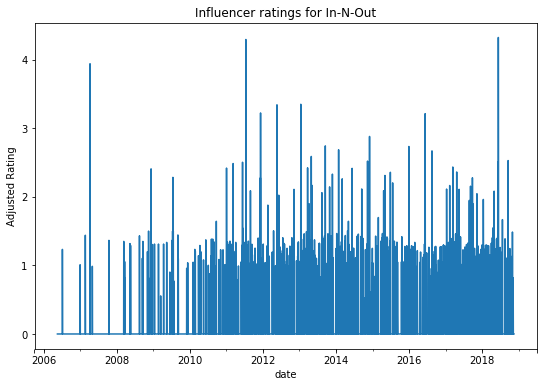

In [26]:
endog['influencer_rating'].plot(figsize=(9,6));
plt.title('Influencer ratings for In-N-Out')
plt.ylabel('Adjusted Rating');

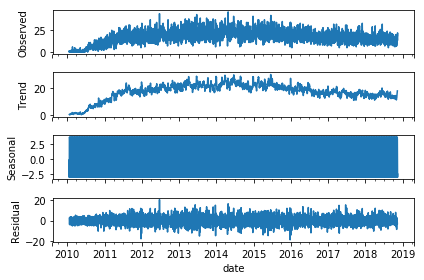

In [34]:
decomposed = sm.seasonal_decompose(endog['checkins'])
decomposed.plot();

In [32]:
for col in endog.columns:
    diff = 0
    pval = sm.stattools.adfuller(endog[col], maxlag=180)[1]
    if pval > 0.001:
        diff+=1
        pval = sm.stattools.adfuller(endog[col].diff()[1:], maxlag=180)[1]
    print("{} - Diff: {}, P-val: {}".format(col, diff, pval))

influencer_rating - Diff: 0, P-val: 0.0
sentiment - Diff: 1, P-val: 5.926362470358938e-24
adj_stars - Diff: 0, P-val: 0.0
checkins - Diff: 1, P-val: 3.1288599529308036e-19


In [16]:
endog.sentiment = endog.sentiment.diff()
endog.checkins = endog.checkins.diff()

In [17]:
# endog = endog.diff()[1:].dropna()
innout_model = sm.VAR(endog.dropna())
innout_model.select_order(maxlags=30, trend='c').summary() # aic = 21

,AIC,BIC,FPE,HQIC
0,0.09910,0.1067,1.104,0.1018
1,-0.4459,-0.4079,0.6403,-0.4323
2,-0.6099,-0.5414,0.5434,-0.5853
3,-0.7238,-0.6249,0.4849,-0.6884
4,-0.8277,-0.6984,0.4371,-0.7813
5,-0.9665,-0.8068,0.3804,-0.9092
6,-1.055,-0.8645,0.3483,-0.9864
7,-1.104,-0.8835*,0.3315,-1.025
8,-1.108,-0.8571,0.3302,-1.018
9,-1.115,-0.8335,0.3279,-1.014


In [18]:
innout_res = innout_model.fit(maxlags=21, ic='aic', trend='c')

In [36]:
print(innout_res.is_stable())
innout_res.test_whiteness(10).summary()

True


Test statistic,Critical value,p-value,df
13.69,nan,NAN,-176


In [38]:
innout_res.names

['influencer_rating', 'sentiment', 'adj_stars', 'checkins']

## Granger causality and IRF

In [39]:
innout_res.test_causality(3, [0,1,2], kind='wald').summary()

Test statistic,Critical value,p-value,df
68.96,82.53,0.283,63


In [40]:
innout_res.test_inst_causality([0, 1, 2]).summary() # orth effects not present

Test statistic,Critical value,p-value,df
2.989,7.815,0.393,3


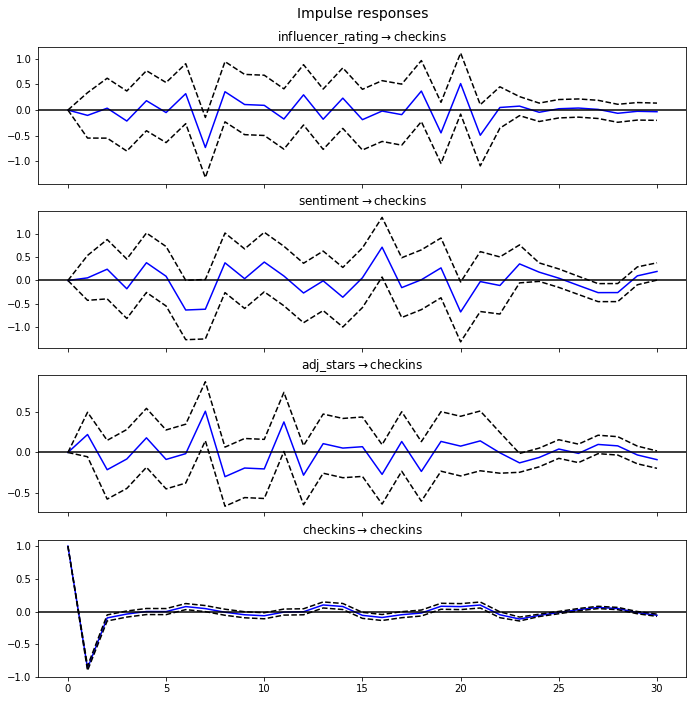

In [19]:
irf = innout_res.irf(periods=30)
irf.plot(orth=False, response='checkins', seed=12345);

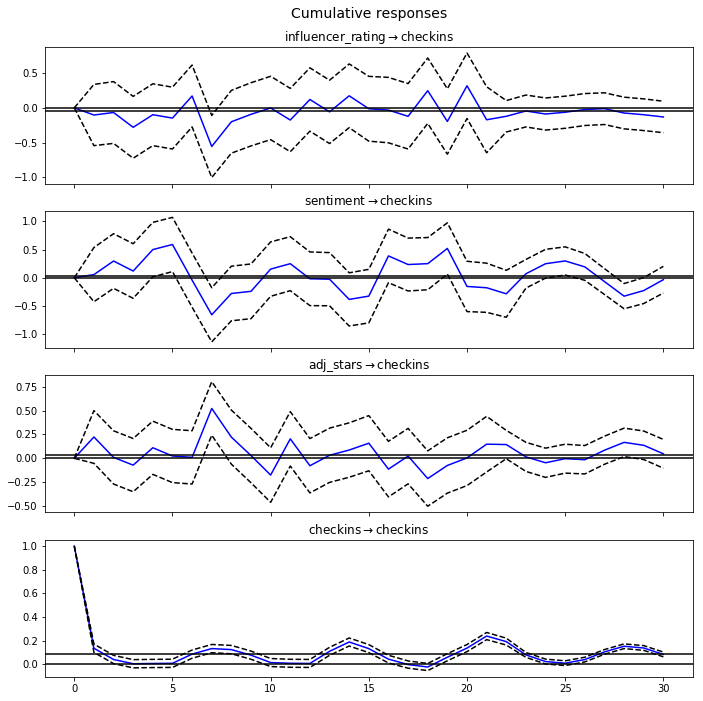

In [45]:
irf.plot_cum_effects(response='checkins', seed=12345);

In [34]:
# save cumulative impact
cum_effects_1wk_after = irf.cum_effects[8][:,3]

In [35]:
cum_effects_3days_after = irf.cum_effects[4][:,3]

In [44]:
pd.DataFrame(irf.cum_effects[1:][:,3], columns=innout_res.names, index=range(1,31)).to_csv('Innout_IRF.csv')

## Deseasonalise

In [81]:
des_endog = endog.dropna().apply(lambda x: sm.seasonal_decompose(x).trend)\
                 .dropna().diff()[1:]

In [82]:
des_endog.apply(lambda x: sm.adfuller(x, maxlag=365)[1])

sentiment            2.658331e-10
influencer_rating    9.253923e-10
stars                2.752207e-08
checkins             2.070943e-05
dtype: float64

In [84]:
des_innout_model = sm.VAR(des_endog)
des_innout_model.select_order(maxlags=30, trend='c').summary() # 28

,AIC,BIC,FPE,HQIC
0,-12.56,-12.55,3.520e-06,-12.55
1,-12.55,-12.52,3.527e-06,-12.54
2,-12.56,-12.49,3.507e-06,-12.54
3,-12.56,-12.46,3.522e-06,-12.52
4,-12.55,-12.42,3.537e-06,-12.51
5,-12.55,-12.39,3.534e-06,-12.50
6,-12.55,-12.36,3.551e-06,-12.48
7,-13.72,-13.50,1.095e-06,-13.65
8,-13.72,-13.47,1.096e-06,-13.63
9,-13.72,-13.44,1.100e-06,-13.62


In [85]:
des_innout_res = des_innout_model.fit(maxlags=28, ic='aic', trend='c')
print(des_innout_res.is_stable())
des_innout_res.test_whiteness(10).summary()

True


Test statistic,Critical value,p-value,df
23.60,nan,NAN,-288


In [87]:
des_innout_model.endog_names

['sentiment', 'influencer_rating', 'stars', 'checkins']

In [89]:
des_innout_res.test_causality(3, [0,1,2], kind='wald').summary()

Test statistic,Critical value,p-value,df
97.57,106.4,0.148,84


In [90]:
des_innout_res.test_inst_causality([0,1,2]).summary()

Test statistic,Critical value,p-value,df
3.259,7.815,0.353,3


In [ ]:
des_irf = des_innout_res.irf(periods=28)

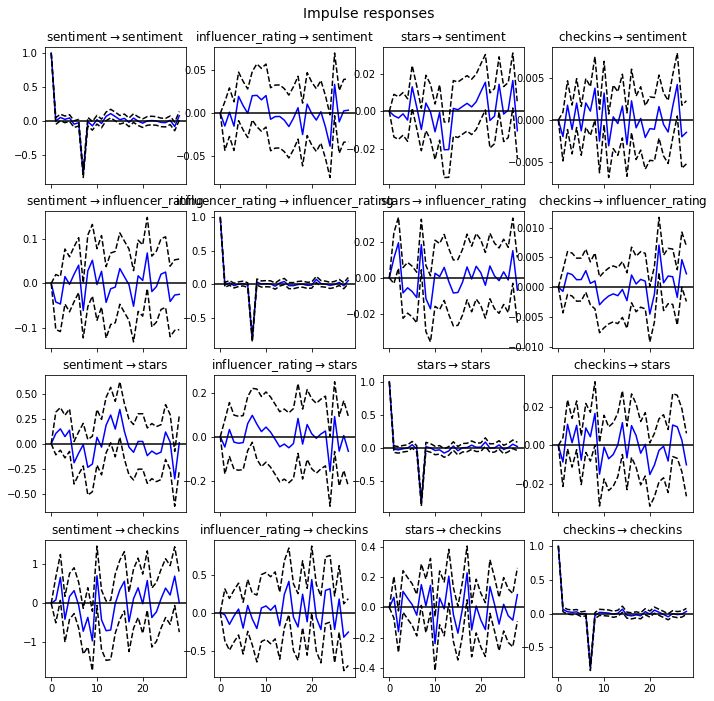

In [96]:
des_irf.plot(orth=False, seed=12345);

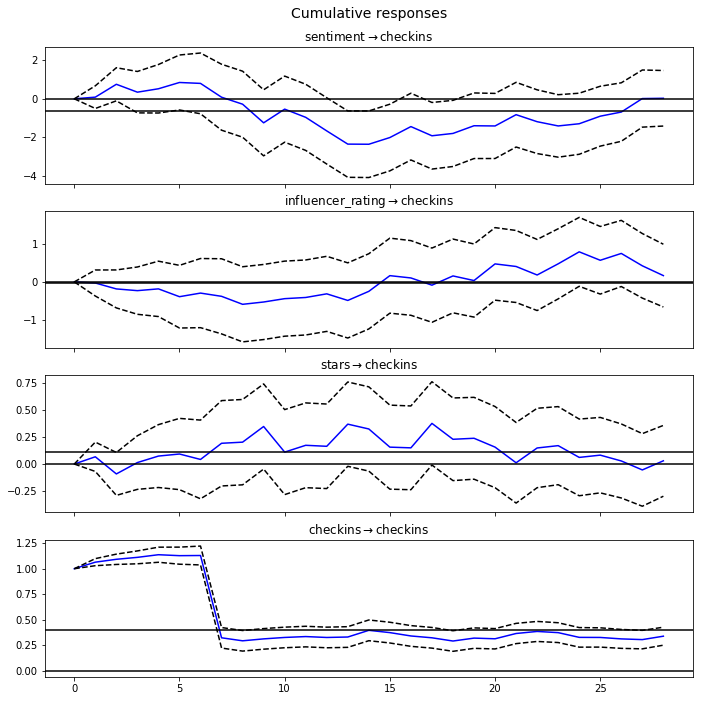

In [95]:
des_irf.plot_cum_effects(response='checkins', seed=12345);

In [48]:
irf.irfs

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 1.67884325e-02, -2.96847622e-02,  7.32164563e-03,
         -7.35840187e-04],
        [-2.68261606e-02, -9.63158631e-01, -1.75073192e-02,
         -1.40148749e-03],
        [-4.18141787e-02,  1.31377512e-02,  1.92195265e-02,
         -7.40646704e-03],
        [-1.03430272e-01,  5.59221371e-02,  2.22904414e-01,
         -8.62685485e-01]],

       [[-2.30668571e-02,  7.94583027e-03,  1.90463569e-02,
          2.84282165e-03],
        [ 3.18941154e-02,  4.10117551e-02,  1.62077943e-02,
          3.83590546e-03],
        [ 4.69909212e-02,  1.61796312e-02, -2.19174000e-03,
          2.30740476e-03],
        [ 3.64348294e-02,  2.41240969e-

# Shake Shack

In [25]:
pd.to_datetime(checkins.date.sum()).dayofweek.value_counts() # sat and sun top

6    4856
5    4736
4    2914
0    2910
1    1990
3    1987
2    1777
dtype: int64

In [26]:
checkins.date.apply(len) # checkins dominated by 1 store

30771       379
33899       235
53590       331
56924       325
67071       862
69351     14975
82754        88
108977      507
119641     1910
145394     1558
Name: date, dtype: int64

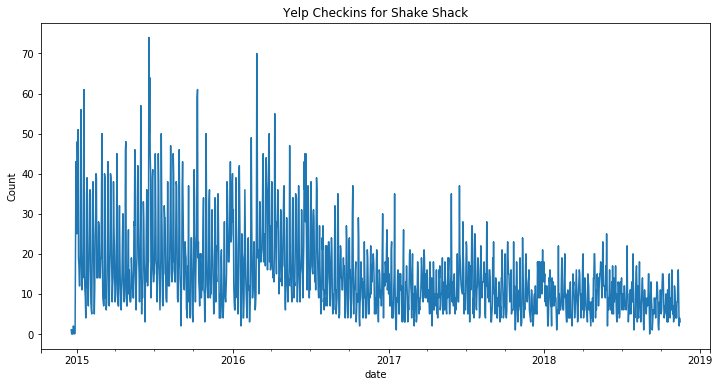

In [87]:
shake_checkin_times.plot(figsize=(12,6))
plt.title('Yelp Checkins for Shake Shack')
plt.ylabel('Count');

In [45]:
df_shake = preprocess('yelp_dataset/review.json', 'yelp_dataset/user.json', shakeshack.index.tolist())
shake_checkin_times = preprocess_checkins('./yelp_dataset/checkin.json', shakeshack.index.tolist())

In [46]:
endog = df_shake.groupby('date').agg({'adj_stars':np.mean,
                                      'sentiment':np.mean,
                                      'influencer_rating':np.sum})
endog = endog.asfreq('D').fillna(0.0)
endog['checkins'] = shake_checkin_times

## Explore time series

Text(0,0.5,'Stars')

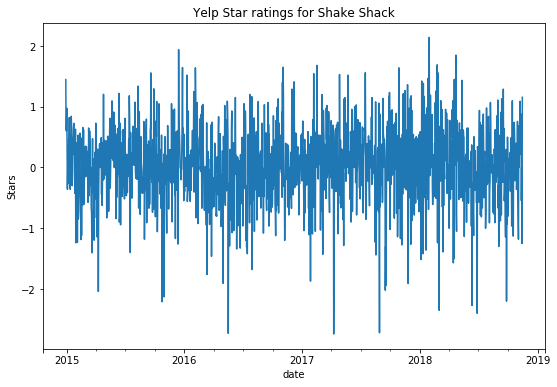

In [56]:
endog['adj_stars'].plot(figsize=(9,6));
plt.title('Yelp Star ratings for Shake Shack')
plt.ylabel('Stars')

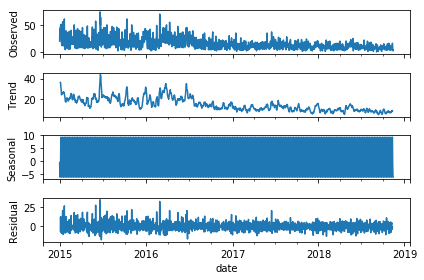

In [47]:
sm.seasonal_decompose(endog['checkins']).plot();

## Check stationarity of each endog variable

In [70]:
for col in endog.columns:
    diff = 0
    pval = sm.stattools.adfuller(endog[col], maxlag=180)[1]
    if pval > 0.001:
        diff+=1
        pval = sm.stattools.adfuller(endog[col].diff()[1:], maxlag=180)[1]
    print("{} - Diff: {}, P-val: {}".format(col, diff, pval))

influencer_rating - Diff: 0, P-val: 8.20184669479371e-14
sentiment - Diff: 0, P-val: 0.0
adj_stars - Diff: 0, P-val: 0.0
checkins - Diff: 1, P-val: 1.0379278248391083e-10


In [62]:
sm.stattools.adfuller(
    sm.seasonal_decompose(endog.checkins.dropna()).trend.diff().dropna(),
    maxlag=180)[1]

4.690338576574207e-09

In [47]:
endog.checkins = endog.checkins.diff()

In [48]:
shake_model = sm.VAR(endog.dropna())
shake_model.select_order(maxlags=30, trend='c').summary() # aic = 13, bic = 6, use 13 and see

,AIC,BIC,FPE,HQIC
0,-0.8148,-0.7997,0.4427,-0.8091
1,-0.7986,-0.7231,0.4499,-0.7704
2,-0.8072,-0.6712,0.4461,-0.7563
3,-0.9048,-0.7084,0.4046,-0.8313
4,-1.034,-0.7772,0.3556,-0.9379
5,-1.275,-0.9573,0.2796,-1.156
6,-1.358,-0.9804*,0.2572,-1.217*
7,-1.343,-0.9054,0.2610,-1.180
8,-1.348,-0.8497,0.2597,-1.162
9,-1.346,-0.7870,0.2603,-1.137


In [49]:
results = shake_model.fit(maxlags=13, ic='aic', trend='c')
print(results.is_stable())
results.test_whiteness(nlags=13).summary()

True


Test statistic,Critical value,p-value,df
46.54,nan,NAN,0


## Granger Causality and Impulse Response analysis

In [66]:
results.names

['influencer_rating', 'sentiment', 'adj_stars', 'checkins']

In [67]:
results.test_causality(3, causing=[0,1,2], kind='f').summary()

Test statistic,Critical value,p-value,df
1.101,1.402,0.308,"(39, 5400)"


In [68]:
results.test_inst_causality(causing=[0,1,2]).summary() # no orthogonal effects

Test statistic,Critical value,p-value,df
2.222,7.815,0.528,3


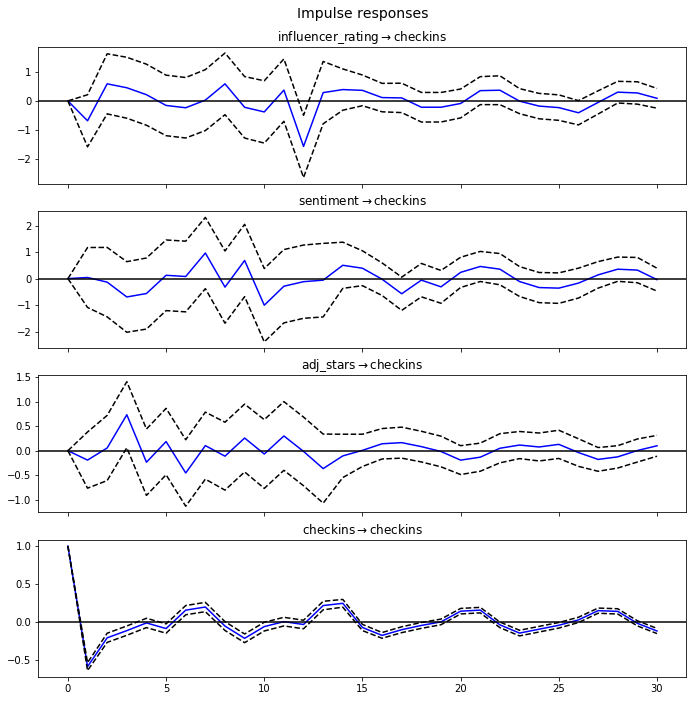

In [50]:
irf = results.irf(periods=30)
irf.plot(orth=False, response='checkins', seed=12345);

In [51]:
# save cumulative effects
pd.DataFrame(irf.cum_effects[1:][:,3], columns=results.names, index=range(1,31)).to_csv('Shakeshack_IRF.csv')

In [75]:
endog['checkin_deseasoned'] = sm.seasonal_decompose(endog.checkins).trend.diff()

In [76]:
deseasoned_mod = sm.VAR(endog[['checkin_deseasoned', 'adj_stars', 'influencer_rating', 'sentiment']].dropna())
deseasoned_mod.select_order(maxlags=30, trend='c').summary() # aic = 15, bic = 6, use 13 and see

,AIC,BIC,FPE,HQIC
0,-4.844,-4.829,0.007876,-4.838
1,-4.951,-4.875*,0.007080,-4.922
2,-4.950,-4.814,0.007081,-4.899
3,-4.940,-4.743,0.007153,-4.866
4,-4.935,-4.677,0.007191,-4.839
5,-4.937,-4.618,0.007178,-4.818
6,-4.936,-4.557,0.007185,-4.794
7,-5.145,-4.706,0.005827,-4.981
8,-5.182,-4.682,0.005616,-4.995*
9,-5.190,-4.630,0.005570,-4.981


In [77]:
deseasoned_res = deseasoned_mod.fit(maxlags=15, ic='aic', trend='c')

In [78]:
print(deseasoned_res.is_stable())
deseasoned_res.test_whiteness(nlags=22).summary()

True


Test statistic,Critical value,p-value,df
226.3,137.7,0.000,112


In [80]:
deseasoned_res.test_causality(0, [1,2,3]).summary()

Test statistic,Critical value,p-value,df
1.246,1.373,0.126,"(45, 5336)"


In [81]:
deseasoned_res.test_inst_causality([1,2,3]).summary()

Test statistic,Critical value,p-value,df
4.573,7.815,0.206,3


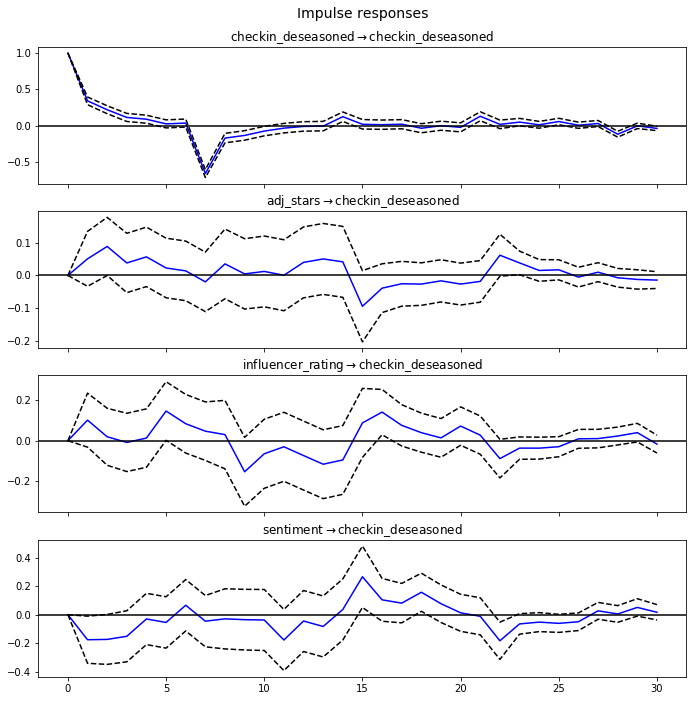

In [82]:
des_irf = deseasoned_res.irf(periods=30)
des_irf.plot(orth=False, response='checkin_deseasoned', seed=12345);

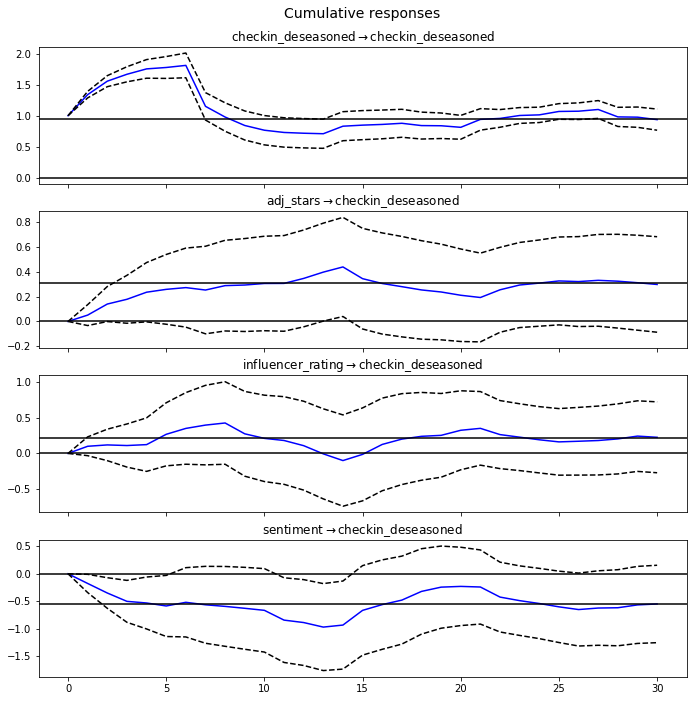

In [85]:
# cumulative effects over time per unit impulse
des_irf.plot_cum_effects(orth=False, response='checkin_deseasoned', seed=12345);

# Cheesecake Factory

In [52]:
df_cheese = preprocess('yelp_dataset/review.json', 'yelp_dataset/user.json', cheesecake.index.tolist())
cheese_checkin_times = preprocess_checkins('./yelp_dataset/checkin.json', cheesecake.index.tolist())

In [143]:
pd.to_datetime(checkins.date.sum()).dayofweek.value_counts() # sat and sun top

6    5401
5    4869
4    3280
0    3173
3    2828
2    2696
1    2628
dtype: int64

In [144]:
checkins.date.apply(len) # checkins dominated by several stores, more even distr.

1451      2781
6002       641
12084     1953
16752     1749
20575      626
48050     2252
48214     3656
56233     1613
62893     1199
73804     1002
97942      242
104918    1400
107577     718
107868    3791
116307     383
150634     869
Name: date, dtype: int64

## Explore Time Series

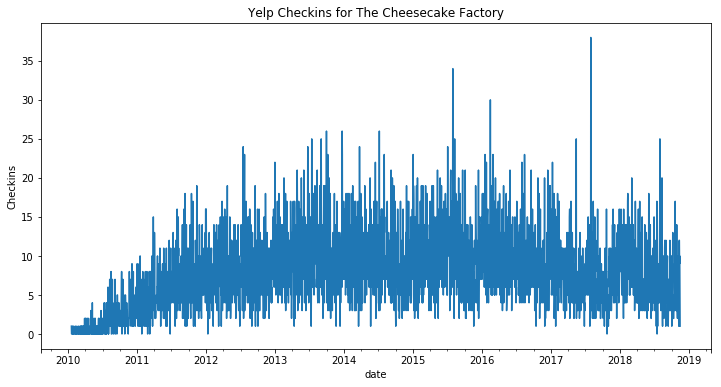

In [90]:
cheese_checkin_times.plot(figsize=(12,6));
plt.title('Yelp Checkins for The Cheesecake Factory')
plt.ylabel('Checkins');

In [94]:
endog = df_cheese.groupby('date').agg({'adj_stars':np.mean,
                                       'sentiment':np.mean,
                                       'influencer_rating':np.sum})
endog = endog.asfreq('D').fillna(0.0)
endog['checkins'] = checkin_times

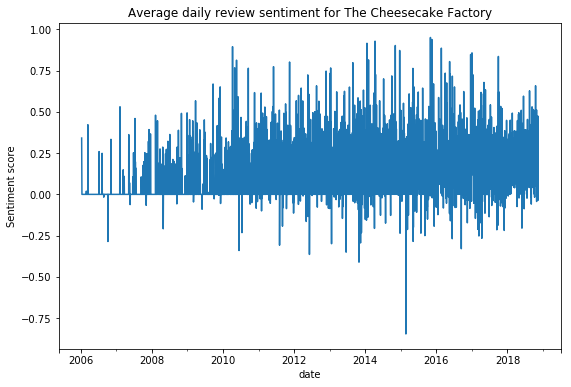

In [164]:
cheese_endog.sentiment.plot(figsize=(9,6));
plt.title('Average daily review sentiment for The Cheesecake Factory')
plt.ylabel('Sentiment score');

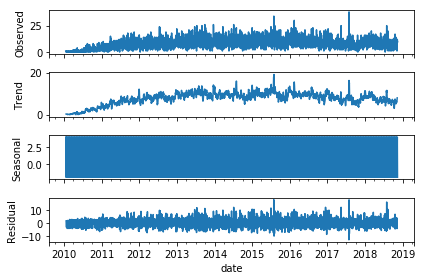

In [167]:
decomposed = sm.seasonal_decompose(cheese_endog['checkins'].dropna())
decomposed.plot();

## Check Stationarity

In [96]:
endog = endog.dropna()

In [97]:
for col in endog.columns:
    diff = 0
    pval = sm.stattools.adfuller(endog[col], maxlag=180)[1]
    if pval > 0.001:
        diff+=1
        pval = sm.stattools.adfuller(endog[col].diff()[1:], maxlag=180)[1]
    print("{} - Diff: {}, P-val: {}".format(col, diff, pval))

influencer_rating - Diff: 0, P-val: 0.0
sentiment - Diff: 0, P-val: 7.634313728946933e-08
adj_stars - Diff: 0, P-val: 6.368648230517212e-16
checkins - Diff: 1, P-val: 3.115169615839443e-19


In [53]:
endog.checkins = endog.checkins.diff()

In [54]:
cheese_model = sm.VAR(endog.dropna())
cheese_model.select_order(30, trend='c').summary() # aic = 21

,AIC,BIC,FPE,HQIC
0,-0.08912,-0.07400,0.9147,-0.08346
1,-0.2876,-0.2120,0.7501,-0.2593
2,-0.3285,-0.1925,0.7200,-0.2776
3,-0.3825,-0.1860,0.6821,-0.3090
4,-0.4350,-0.1780,0.6473,-0.3389
5,-0.6448,-0.3274,0.5248,-0.5261
6,-0.9591,-0.5812,0.3832,-0.8178
7,-1.137,-0.6992*,0.3206,-0.9735*
8,-1.156,-0.6574,0.3147,-0.9696
9,-1.170,-0.6112,0.3103,-0.9613


In [55]:
cheese_res = cheese_model.fit(maxlags=21, ic='aic', trend='c')
print(cheese_res.is_stable())
cheese_res.test_whiteness(nlags=30).summary()

True


Test statistic,Critical value,p-value,df
227.0,173.0,0.000,144


## Granger causality and IRF

In [101]:
cheese_res.names

['influencer_rating', 'sentiment', 'adj_stars', 'checkins']

In [102]:
cheese_res.test_causality(3, [0,1,2]).summary()

Test statistic,Critical value,p-value,df
1.014,1.311,0.446,"(63, 12460)"


In [103]:
cheese_res.test_inst_causality([0,1,2]).summary()
# orthogonal effects present

Test statistic,Critical value,p-value,df
2.209,7.815,0.530,3


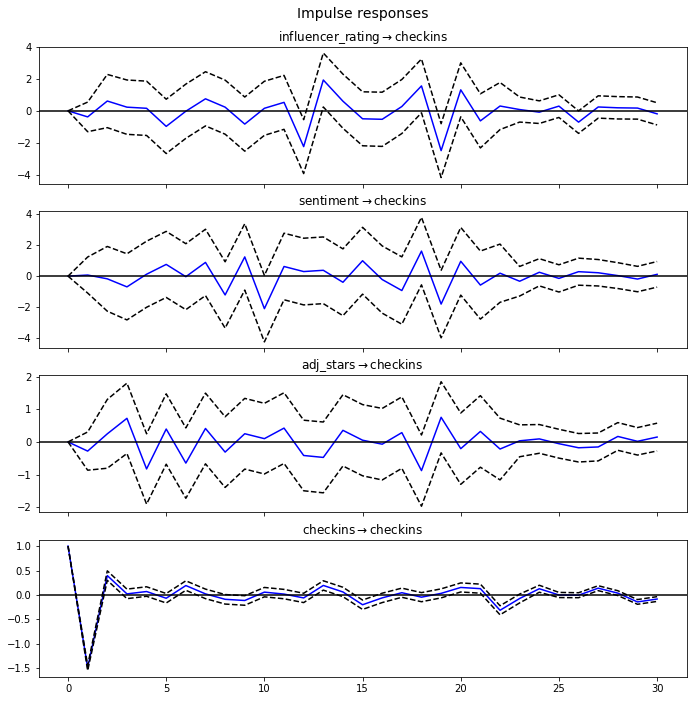

In [56]:
irf = cheese_res.irf(periods=30)
irf.plot(orth=False, response='checkins', seed=12345);

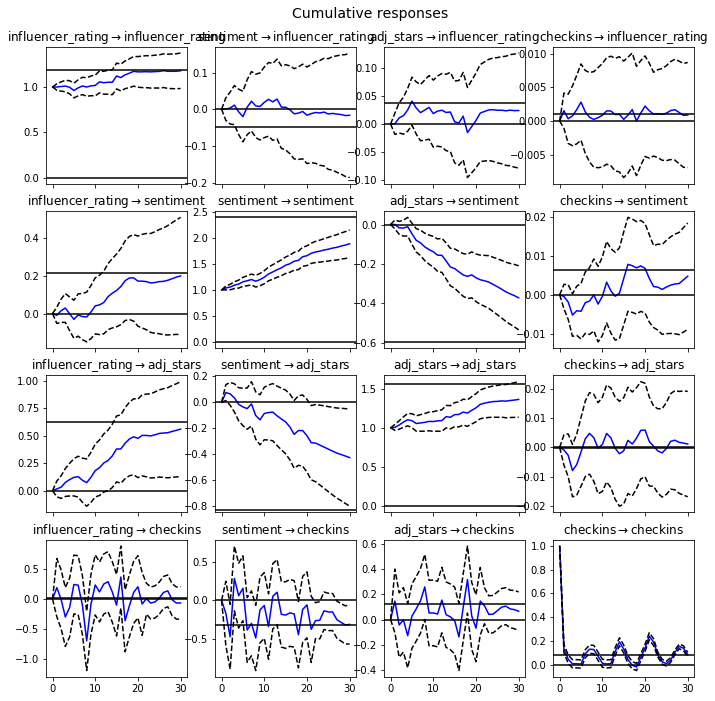

In [112]:
irf.plot_cum_effects();

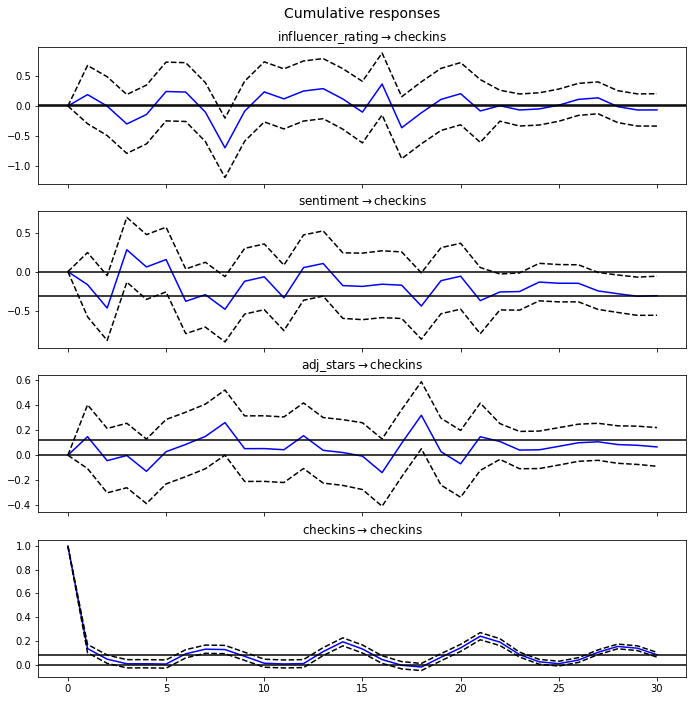

In [106]:
irf.plot_cum_effects(response='checkins', seed=12345);

In [57]:
pd.DataFrame(irf.cum_effects[1:][:,3], 
             columns=cheese_res.names,
             index=range(1,31)).to_csv('Cheesecake_IRF.csv')

In [114]:
endog.checkins = sm.seasonal_decompose(cheese_endog['checkins'].dropna()).trend.diff()

In [115]:
# use deseasonalized checkins instead
des_cheese_model = sm.VAR(endog.dropna())
des_cheese_model.select_order(maxlags=20, trend='c').summary() # aic = 15

,AIC,BIC,FPE,HQIC
0,-4.338,-4.330,0.01306,-4.335
1,-4.340,-4.302,0.01304,-4.326
2,-4.340,-4.272,0.01304,-4.316
3,-4.340,-4.241,0.01304,-4.304
4,-4.338,-4.209,0.01306,-4.292
5,-4.342,-4.182,0.01301,-4.285
6,-4.343,-4.153,0.01300,-4.275
7,-4.638,-4.418*,0.009678,-4.559
8,-4.637,-4.386,0.009688,-4.547
9,-4.636,-4.354,0.009701,-4.535


In [116]:
des_cheese_res = des_cheese_model.fit(maxlags=15, ic='aic', trend='c')
print(des_cheese_res.is_stable())
des_cheese_res.test_whiteness(nlags=30).summary()

True


Test statistic,Critical value,p-value,df
543.1,277.1,0.000,240


In [117]:
des_cheese_res.names

['influencer_rating', 'sentiment', 'adj_stars', 'checkins']

In [118]:
des_cheese_res.test_causality(3, [0,1,2]).summary()

Test statistic,Critical value,p-value,df
1.115,1.371,0.276,"(45, 12556)"


In [119]:
des_cheese_res.test_inst_causality([0,1,2]).summary() # no orth effects

Test statistic,Critical value,p-value,df
1.916,7.815,0.590,3


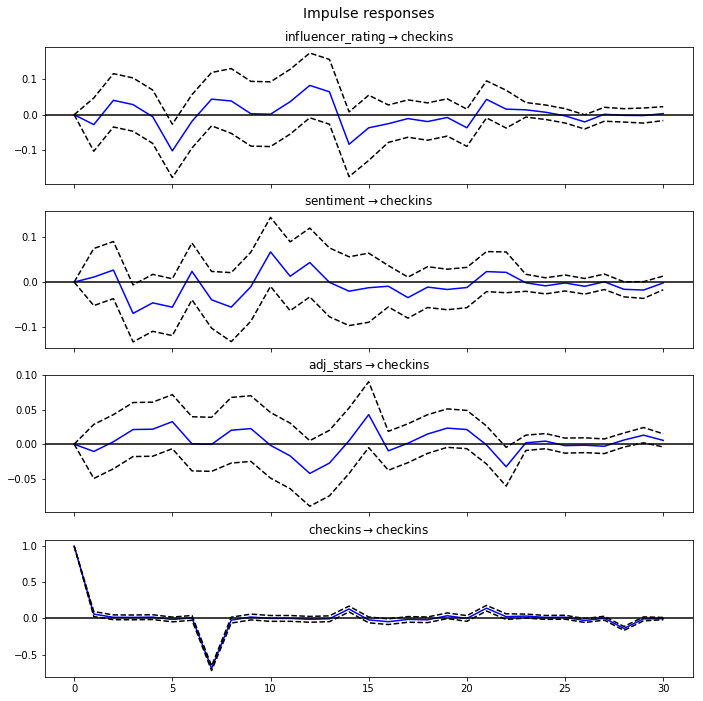

In [120]:
irf = des_cheese_res.irf(periods=30)
irf.plot(orth=False, response='checkins', seed=12345);

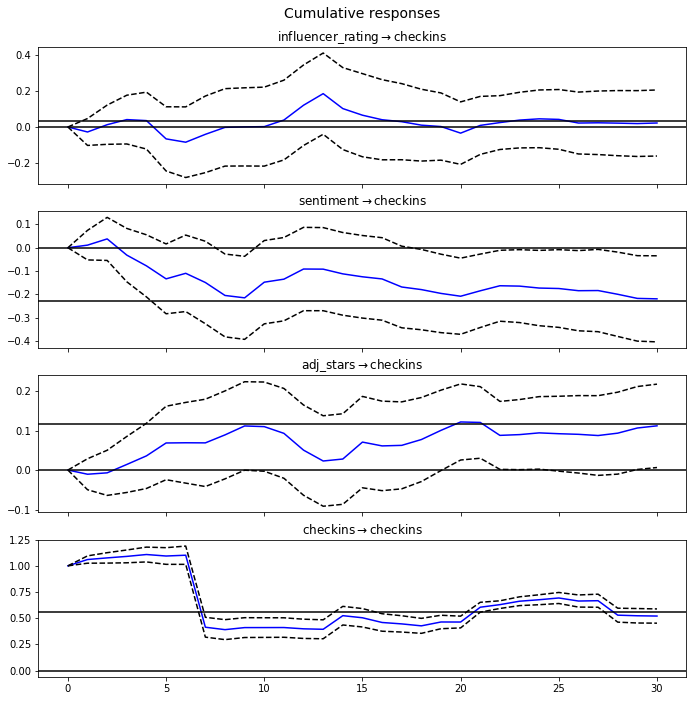

In [122]:
irf.plot_cum_effects(response='checkins', seed=12345);

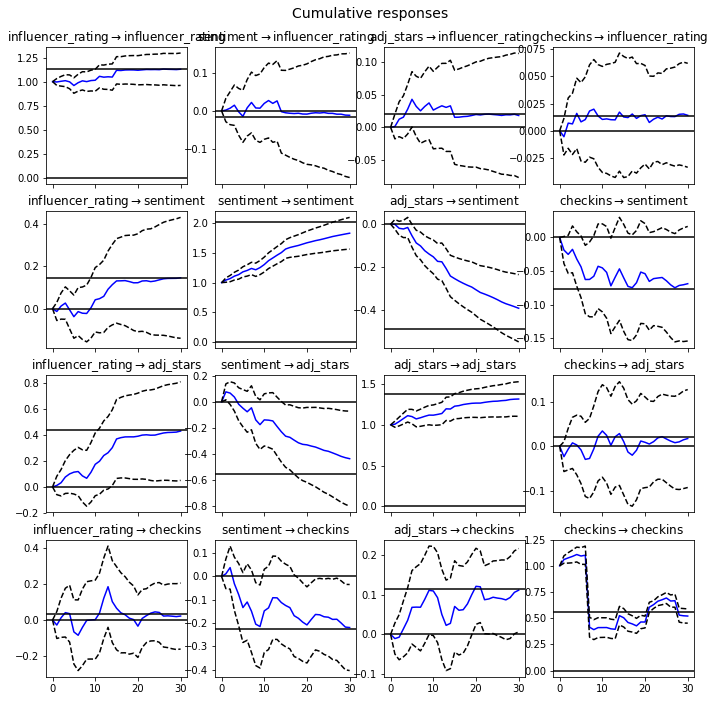

In [123]:
irf.plot_cum_effects(seed=12345);